# Analysis of testData0

**Author**: Jacopo Ventura

**Date**: 22nd October 2017

A predictive model for the feature $t$ is build through the following steps:

1. import data and perform descriptive statistics
2. first plots of the data to get insights
3. check linear correlation
4. separate training and test sets
5. train few machine learning algorithms and select the best one 
6. outliers removal
7. train again the chosen machine learning algorithm without outliers
8. test the algorithm on the test dataset


In [1]:
# Import packages for data analysis
import os    # OS module provides the interface with the operating system and allows to use it
import tarfile
from six.moves import urllib
import pandas as pd     # Pandas: python library for large data manipulation and analysis. 
                        # Dataset will be saved as Pands dataset
import numpy as np
import matplotlib.pyplot as plt

# this command is very important in Jupyter: figures must be showed directly in the notebook!!!
%matplotlib inline

# disable warnings
import warnings
warnings.filterwarnings("ignore")

### Step 1: import csv data into pandas' dataframe  

In [2]:
# step 1: acquire dataset
data_path='C:/Users/jacopo/Desktop/schaeffler/testData0.csv'
dataset = pd.read_csv(data_path,sep=';')   # dataset as pandas dataset

print('Overview of the dataset: size of dataset and type of data:\n')
dataset.info()

print('\nDescriptive statistics of the dataset:')
dataset.describe()

Overview of the dataset: size of dataset and type of data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
a    1000 non-null float64
b    1000 non-null float64
c    1000 non-null float64
t    1000 non-null float64
dtypes: float64(4)
memory usage: 31.3 KB

Descriptive statistics of the dataset:


,a,b,c,t
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,202.008950,145.109240,1250.018260,1162.593320
std,113.724002,60.634722,1046.962337,734.485696
min,0.400000,40.100000,-495.990000,-3194.230000
25%,100.942500,92.717500,326.785000,713.780000
50%,199.560000,144.575000,1256.810000,1141.995000
75%,302.542500,196.727500,2201.947500,1599.465000
max,399.160000,249.560000,2998.480000,6075.050000


The dataset consists of 1000 instances composed by 3 attributes ($a$,$b$,$c$) and the target attribute $t$. Values are numerical  $float64$. Moreover, **the dataset is complete**, meaning that no missing data (NaN) are present.

From the descriptive statistics we can observe that the feature $c$ is one order of magnitude greater than $a$ and $b$. It will be necessary to scale the data before training some Machine Learning models like SVM. 

Moreover, $t$ is continuous numerical. Therefore, predicting $t$ is a **regression task**.


### Step 2: first plots to understand the data


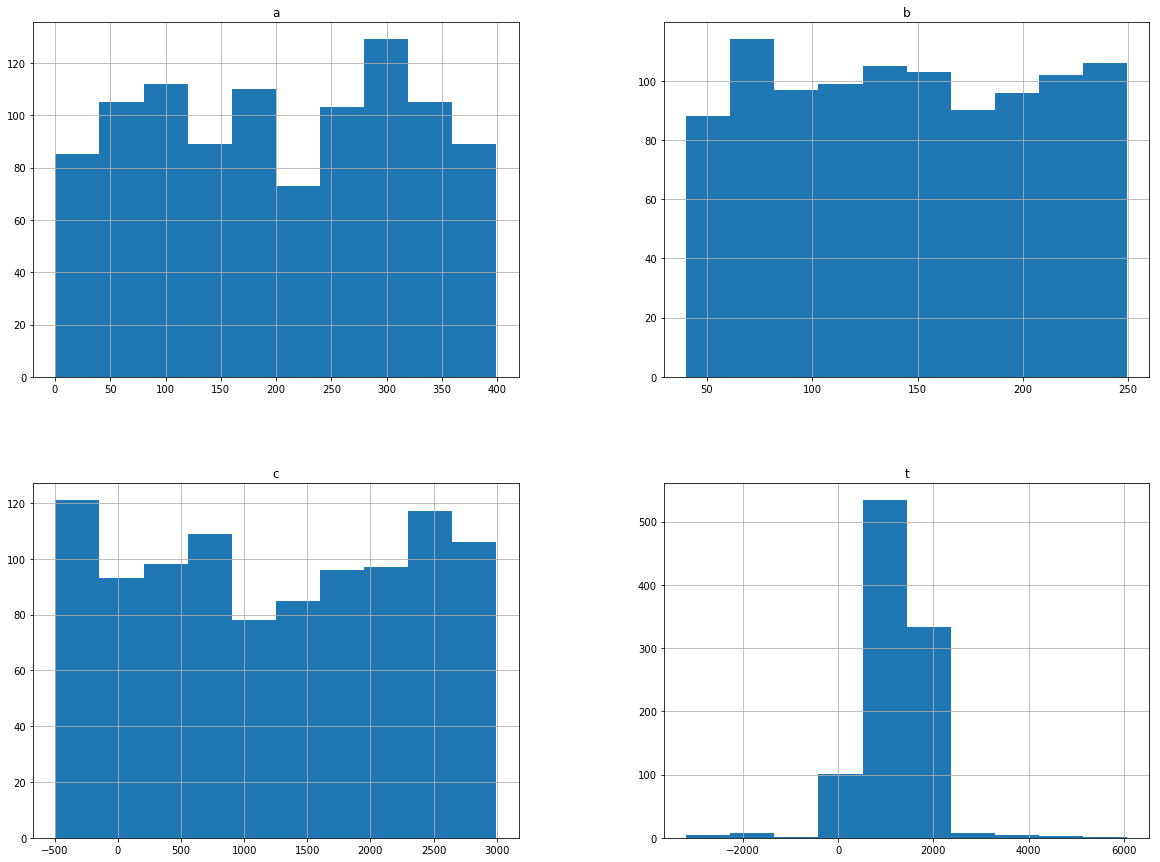

In [3]:
# Histograms of data
dataset.hist(bins=10, figsize=(20,15))
plt.show()

From the previous histograms we can observe that the features $a$, $b$, $c$ have uniform distribution, whereas the target feature $t$ has a peak around 1000.

### Step 3: Check linear correlation through the Pearson's r coefficient

In [4]:
# check linear correlation through Pearson's r
corr_matrix = dataset.corr()
corr_matrix["t"].sort_values(ascending=False)

t    1.000000
b    0.679699
a    0.034032
c    0.008277
Name: t, dtype: float64

The Pearson's r correlation shows that $b$ and $t$ have some linear correlation as the coefficient is 0.68. Therefore, $b$ seems to be the most promising feature for predicting $t$.

Let us now generate the scatter matrix to graphically show this correlation.

Scatter matrix of data:


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000157194C5B00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000015719B1F4A8>]], dtype=object)

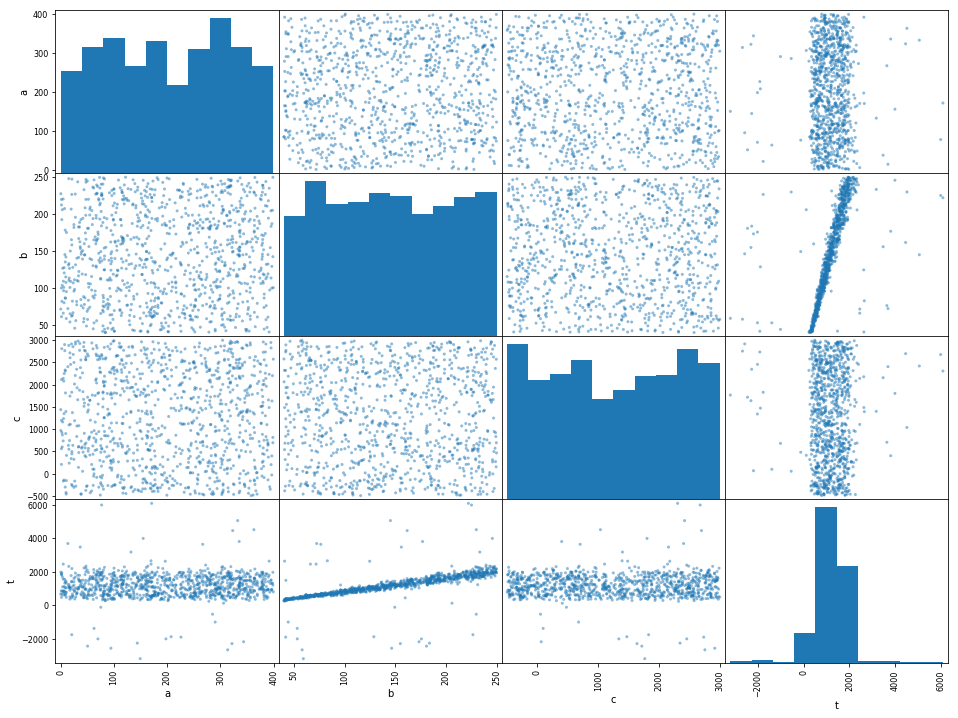

In [5]:
# generate scatter matrix
from pandas.plotting import scatter_matrix

print('Scatter matrix of data:')
scatter_matrix(dataset, figsize=(16, 12))

The scatter matrix shows the **linear correlation between $b$ and $t$**. Some outliers are present and therefore decrease the pearsons' r coefficient.

### Step 4: generate training and test sets

We now separate the dataset into train and test datasets. We impose that the test set is 20% of the input data. Selection is done using random sampling.

In [6]:
# Generation of train and test dataset by random sampling
from sklearn.cross_validation import train_test_split
 
Features_X = dataset[['a','b','c']]
Label_Y = dataset['t']
train_Features, test_Features, train_Label, test_Label = train_test_split(Features_X, 
                                                                            Label_Y, 
                                                                            test_size=0.2,
                                                                            random_state=41)

print(len(train_Features), "train +", len(test_Features), "test")

800 train + 200 test


D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler_Feature = MinMaxScaler().fit(train_Features)
scaler_Label = MinMaxScaler().fit(train_Label)

train_Features_scaled = scaler_Feature.transform(train_Features)
train_Label_scaled = scaler_Label.transform(train_Label)



D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


### Step 5: training of Machine Learning models

By looking at the scatter matrix generated in Step 3, it would be possible to use linear regression only. However, it is usual to train few Machine Learning models and than choose the one having the smallest error (computed via cross validation). Subsequently, the best performing one is selected for fine tuning. 

The following Machine Learning models are trained:

1. Linear regression
2. SVM
3. Random Forest
4. KNN


In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# options for cross validation
score_cross_val = "neg_mean_squared_error"
N_split = 10

# function to display results from cross validation
def display_scores(scores):
    print('Performance measure for cross validation: mean squared error')
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [9]:
# 1: Linear regression
from sklearn.linear_model import LinearRegression

# train linear regression
lin_reg = LinearRegression()
lin_reg.fit(train_Features_scaled, train_Label_scaled)

# cross validation on the training dataset
scores = cross_val_score(lin_reg,train_Features_scaled,
                         train_Label_scaled,
                         scoring=score_cross_val, 
                         cv=N_split)

lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Performance measure for cross validation: mean squared error
Mean: 0.0566469393826
Standard deviation: 0.0205557300805


In [18]:
# 2: SVM
from sklearn.svm import SVR
svr_reg = SVR(kernel='rbf',
              C = 100,
              gamma = 'auto')

svr_reg.fit(train_Features_scaled, train_Label_scaled)

# cross validation on the training dataset
scores = cross_val_score(svr_reg,train_Features_scaled,
                         train_Label_scaled,
                         scoring=score_cross_val, 
                         cv=N_split)

tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Performance measure for cross validation: mean squared error
Mean: 0.0810825165693
Standard deviation: 0.0158977077903


In [23]:
# 3: Random Forest
from sklearn.ensemble import RandomForestRegressor

# train Random Forest
forest_reg = RandomForestRegressor(n_estimators = 50,
                                   criterion='mse', 
                                   max_depth=None, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, 
                                   max_features='auto', 
                                   max_leaf_nodes=None, 
                                   min_impurity_split=1e-07, 
                                   bootstrap=True
                                  )
forest_reg.fit(train_Features_scaled, train_Label_scaled)


# cross validation on the training dataset
scores = cross_val_score(forest_reg,train_Features_scaled,
                         train_Label_scaled,
                         scoring=score_cross_val, 
                         cv=N_split)

forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Performance measure for cross validation: mean squared error
Mean: 0.0657860078689
Standard deviation: 0.0143400682423


In [25]:
# 4: kNN
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=4,
                              weights='uniform',
                              algorithm='auto',
                              leaf_size=30,
                              p=2,
                              metric='minkowski')

knn_reg.fit(train_Features_scaled, train_Label_scaled)

# cross validation on the training dataset
scores = cross_val_score(knn_reg,train_Features_scaled,
                         train_Label_scaled,
                         scoring=score_cross_val, 
                         cv=N_split)

forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Performance measure for cross validation: mean squared error
Mean: 0.0650641354787
Standard deviation: 0.0151602471764


As expected, **linear regression** is the best choice for predicting $t$ since the average mean squared error from the cross validation procedure is the lowest (525.1).

### Step 6: outliers elimination

As we can observe in the scatter matrix plot, some outliers are present in the dataset. In particular, outliers can be seen in the plot $(b,t)$. 

To remove the outliers, we apply the following procedure:
1. use the trained linear regression model to predict the value using the training data. 
2. evaluate the squared error of the predicted values
3. elimininate the points having the largest error. Set the number of points to eliminate as 10% of the training data


In [ ]:
# prediction
predictions = lin_reg.predict(train_Features)

# compute squared error and save in array E
E = (train_Label.values-predictions)**2

# select outliers by excluding the 10% points with worst RMSE
idx_sorted = np.argsort(-E)
limit = int(len(train_Features)*0.1)
idx_no_outliers = idx_sorted[limit:]

# create new training without outliers
train_Features_good = train_Features.values[idx_no_outliers]
train_Label_good = train_Label.values[idx_no_outliers]

In [ ]:
# plot the data
b = []
for i in train_Features_good:
    b.append(i[1])
    
train_Features_out = train_Features.values[idx_sorted[:limit]]
train_Label_out = train_Label.values[idx_sorted[:limit]]
b_outlier = []
for i in train_Features_out:
    b_outlier.append(i[1])

plt.scatter(b, train_Label_good,label = 'data')
plt.scatter(b_outlier, train_Label_out, label = 'outlier')
plt.xlabel('b',fontsize=15)
plt.ylabel('t',fontsize=15)
plt.legend()
plt.show()

### Step 7: train a new Linear Regression model using the training set without outliers

We train again the linear regression model using the training set without the outliers detected in the previous step.

In [ ]:
# train linear regression
lin_reg_final = LinearRegression()
lin_reg_final.fit(train_Features_good, train_Label_good)

# cross validation on the training dataset
scores = cross_val_score(lin_reg_final,train_Features_good,
                         train_Label_good,
                         scoring=score_cross_val, 
                         cv=N_split)

lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

By comparing the RMSE after outliers elimination with the same error before outliers elimination, we can clearly see how the new model better fits the data. Notably, the RMSE is now 82.6, whereas it was 525.1 before outliers elimination.

### Step 8: test on the test set

In [ ]:
# test on the test dataset
scores = cross_val_score(lin_reg_final,test_Features,
                         test_Label,
                         scoring=score_cross_val, 
                         cv=N_split)

lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)


The RMSE error is 393.4, which is higher than 82.6 obtained with the training dataset. In fact, some outliers are present also in the test dataset, as the following scatter plot shows.

In [ ]:
# plot test dataset
b = []
for i in test_Features.values:
    b.append(i[1])
    
plt.scatter(b, test_Label)
plt.xlabel('b',fontsize=15)
plt.ylabel('t',fontsize=15)


In [ ]:
plt.show()print('Scatter matrix of data:')
scatter_matrix(dataset, figsize=(16, 12))